In [1]:
# Import All Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.metrics import silhouette_score
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load dataset
file_path = "meena_customer_segmentation_clean.xlsx"
df = pd.read_excel(file_path, sheet_name='Clean_Data')

* Basic insights

In [3]:
print("Shape:", df.shape)

Shape: (45211, 17)


In [4]:
print("\nColumns:", df.columns.tolist())


Columns: ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y']


In [5]:
print("\nFirst 8 rows:")
df.head(8)


First 8 rows:


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,Management,Married,Tertiary,No,2143,1,0,Cellular,5,May,261,1,-1,0,Failure,0
1,44,Technician,Single,Secondary,No,29,1,0,Cellular,5,May,151,1,-1,0,Failure,0
2,33,Entrepreneur,Married,Secondary,No,2,1,1,Cellular,5,May,76,1,-1,0,Failure,0
3,47,Blue-Collar,Married,Secondary,No,1506,1,0,Cellular,5,May,92,1,-1,0,Failure,0
4,33,Blue-Collar,Single,Secondary,No,1,0,0,Cellular,5,May,198,1,-1,0,Failure,0
5,35,Management,Married,Tertiary,No,231,1,0,Cellular,5,May,139,1,-1,0,Failure,0
6,28,Management,Single,Tertiary,No,447,1,1,Cellular,5,May,217,1,-1,0,Failure,0
7,42,Entrepreneur,Divorced,Tertiary,Yes,2,1,0,Cellular,5,May,380,1,-1,0,Failure,0


In [6]:
print("\nNumeric summary:")
df.describe()


Numeric summary:


,age,balance,housing,loan,day,duration,campaign,pdays,previous,y
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,0.555838,0.160226,15.806419,258.163080,2.763841,40.197828,0.580323,0.116985
std,10.618762,3044.765829,0.496878,0.366820,8.322476,257.527812,3.098021,100.128746,2.303441,0.321406
min,18.000000,-8019.000000,0.000000,0.000000,1.000000,0.000000,1.000000,-1.000000,0.000000,0.000000
25%,33.000000,72.000000,0.000000,0.000000,8.000000,103.000000,1.000000,-1.000000,0.000000,0.000000
50%,39.000000,448.000000,1.000000,0.000000,16.000000,180.000000,2.000000,-1.000000,0.000000,0.000000
75%,48.000000,1428.000000,1.000000,0.000000,21.000000,319.000000,3.000000,-1.000000,0.000000,0.000000
max,95.000000,102127.000000,1.000000,1.000000,31.000000,4918.000000,63.000000,871.000000,275.000000,1.000000


In [7]:
print("\nTarget distribution (y):")
print(df['y'].value_counts())


Target distribution (y):
y
0    39922
1     5289
Name: count, dtype: int64


In [8]:
# Data Processing
df['default'] = df['default'].map({'No': 0, 'Yes': 1}).astype(int)
month_order = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
month_map = {m: i+1 for i, m in enumerate(month_order)}
df['month_num'] = df['month'].map(month_map).fillna(0).astype(int)

In [9]:
df_processed = df.drop(columns=['day','month'])
categorical_cols = ['job','marital','education','contact','poutcome']
df_encoded = pd.get_dummies(df_processed, columns=categorical_cols, drop_first=True)

###  EDA

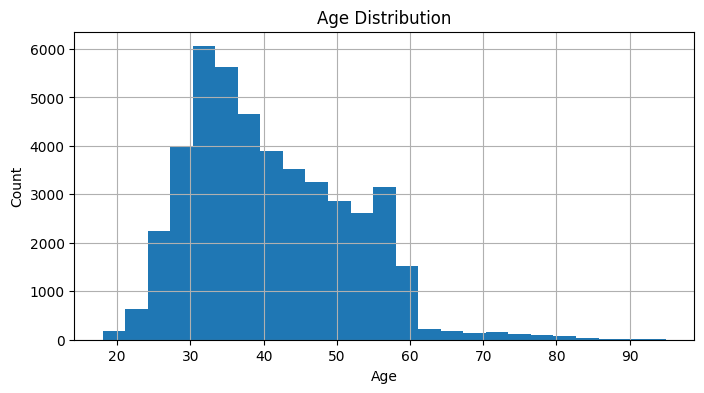

In [10]:
# Plot 1: Age distribution
plt.figure(figsize=(8,4))
plt.hist(df['age'], bins=25)
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Count")
plt.grid(True)
plt.show()

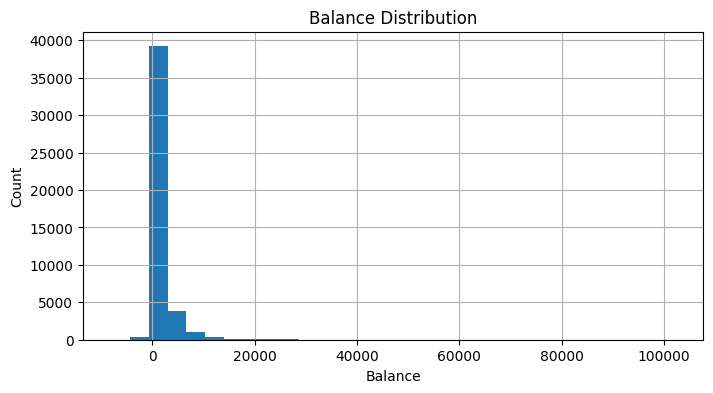

In [11]:
# Plot 2: Balance distribution
plt.figure(figsize=(8,4))
plt.hist(df['balance'], bins=30)
plt.title("Balance Distribution")
plt.xlabel("Balance")
plt.ylabel("Count")
plt.grid(True)
plt.show()

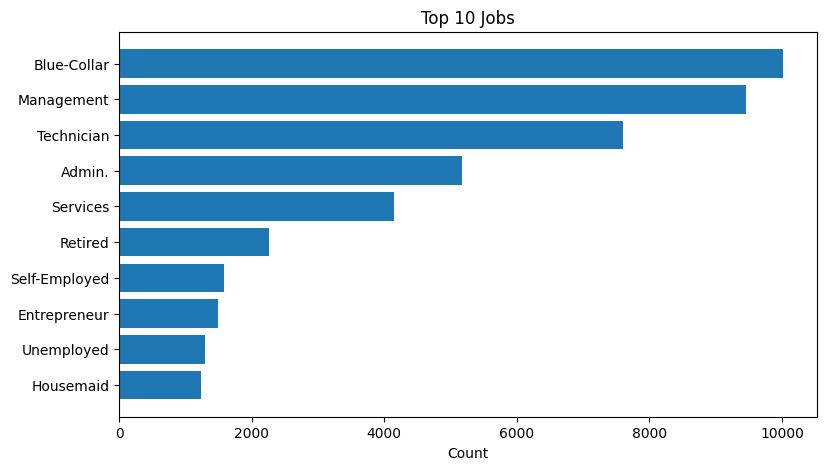

In [12]:
# Plot 3: Top 10 job categories
top_jobs = df['job'].value_counts().nlargest(10)
plt.figure(figsize=(9,5))
plt.barh(top_jobs.index[::-1], top_jobs.values[::-1])
plt.title("Top 10 Jobs")
plt.xlabel("Count")
plt.show()

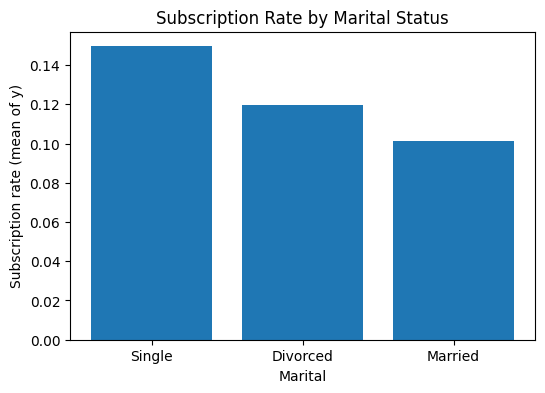

In [13]:
# Plot 4: Subscription rate by marital status
marital_rate = df.groupby('marital')['y'].mean().sort_values(ascending=False)
plt.figure(figsize=(6,4))
plt.bar(marital_rate.index, marital_rate.values)
plt.title("Subscription Rate by Marital Status")
plt.xlabel("Marital")
plt.ylabel("Subscription rate (mean of y)")
plt.show()

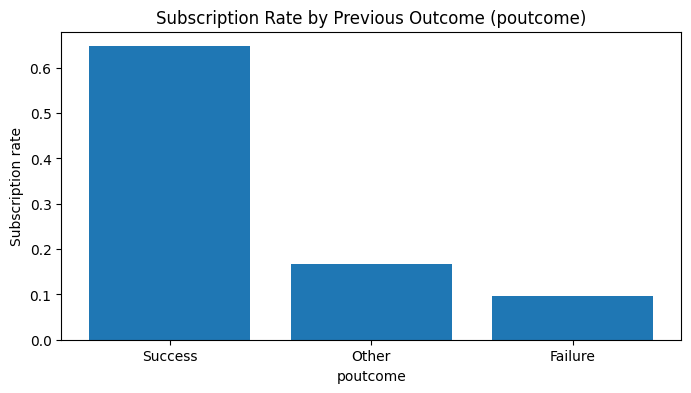

In [14]:
# Plot 5: Subscription rate by previous outcome
poutcome_rate = df.groupby('poutcome')['y'].mean().sort_values(ascending=False)
plt.figure(figsize=(8,4))
plt.bar(poutcome_rate.index, poutcome_rate.values)
plt.title("Subscription Rate by Previous Outcome (poutcome)")
plt.xlabel("poutcome")
plt.ylabel("Subscription rate")
plt.show()

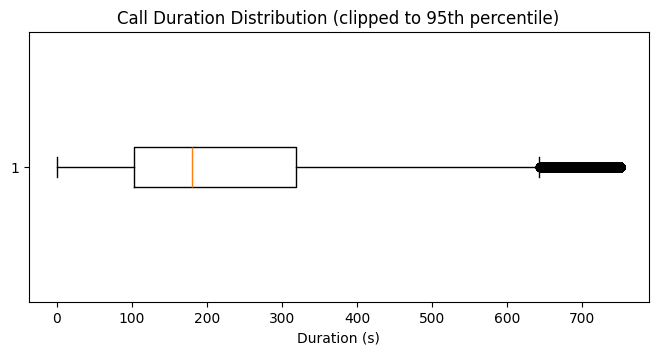

In [15]:
# Plot 6: Call duration boxplot
duration_clip = df['duration'].clip(upper=df['duration'].quantile(0.95))
plt.figure(figsize=(8,3.5))
plt.boxplot(duration_clip, vert=False)
plt.title("Call Duration Distribution (clipped to 95th percentile)")
plt.xlabel("Duration (s)")
plt.show()

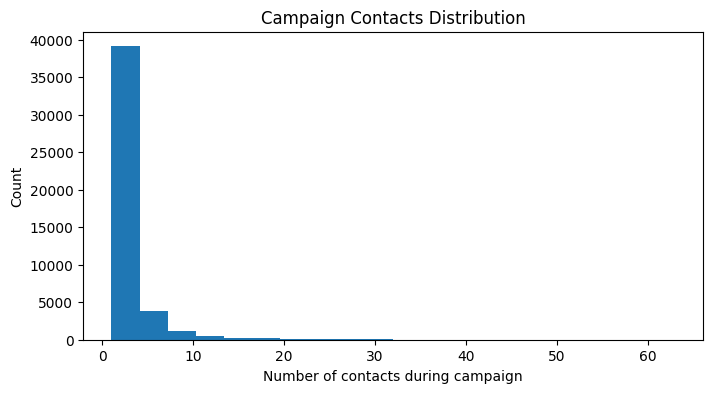

In [16]:
# Plot 7: Campaign contacts distribution
plt.figure(figsize=(8,4))
plt.hist(df['campaign'], bins=20)
plt.title("Campaign Contacts Distribution")
plt.xlabel("Number of contacts during campaign")
plt.ylabel("Count")
plt.show()

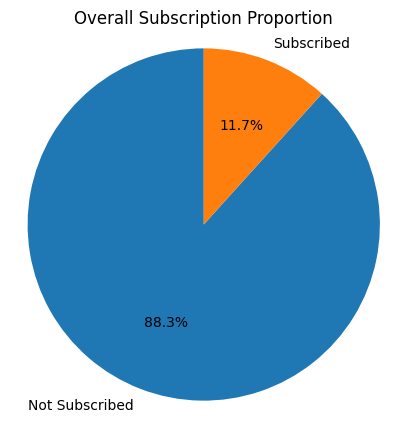

In [17]:
# Plot 8: Overall subscription proportion
plt.figure(figsize=(5,5))
sizes = df['y'].value_counts().sort_index().values
labels = ['Not Subscribed','Subscribed']
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title("Overall Subscription Proportion")
plt.axis('equal')
plt.show()

###  Dataset preprocessing & feature engineering

In [18]:
# PCA
X_features = df_encoded.drop(columns=['y'])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_features)

In [19]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_pca['y'] = df_encoded['y'].values

print("\nExplained variance by PCA:", pca.explained_variance_ratio_)


Explained variance by PCA: [0.09116844 0.08595173]


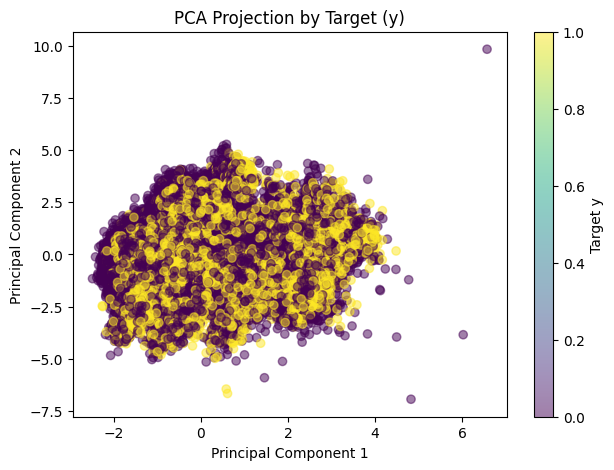

In [20]:
plt.figure(figsize=(7,5))
plt.scatter(df_pca['PC1'], df_pca['PC2'], c=df_pca['y'], cmap='viridis', alpha=0.5)
plt.title("PCA Projection by Target (y)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label='Target y')
plt.show()

In [21]:
# K-Means Clustering
kmeans = KMeans(n_clusters=4, random_state=42)
df_encoded['Cluster'] = kmeans.fit_predict(X_scaled)
silhouette_avg = silhouette_score(X_scaled, df_encoded['Cluster'])
print("\nSilhouette Score (KMeans):", silhouette_avg)


Silhouette Score (KMeans): 0.10115211111057608


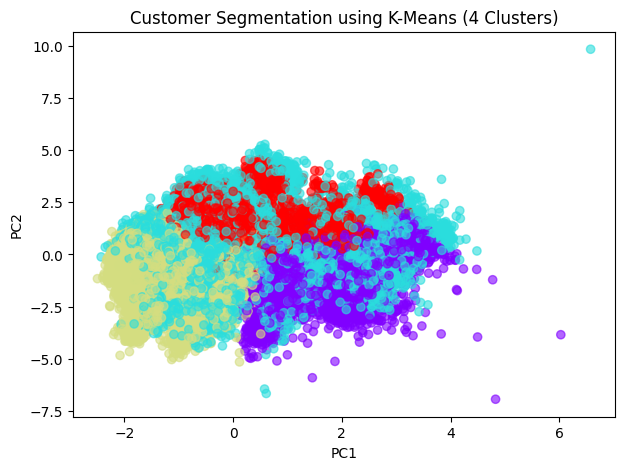

In [22]:
plt.figure(figsize=(7,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=df_encoded['Cluster'], cmap='rainbow', alpha=0.6)
plt.title("Customer Segmentation using K-Means (4 Clusters)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [23]:
# Analyze average profile of each cluster
cluster_profile = df_encoded.groupby('Cluster').mean()
print("\nCluster-wise Average Profile:\n")
cluster_profile.head()


Cluster-wise Average Profile:



,age,default,balance,housing,loan,duration,campaign,pdays,previous,y,...,job_Student,job_Technician,job_Unemployed,marital_Married,marital_Single,education_Secondary,education_Tertiary,contact_Telephone,poutcome_Other,poutcome_Success
Cluster,,,,,,,,,,,,,,,,,,,,,
0,40.783533,0.017387,1819.247838,0.483717,0.144710,252.631923,2.913983,23.485189,0.300644,0.112695,...,0.001656,0.091260,0.013431,0.612695,0.261178,0.000276,0.974241,0.047930,0.000000,0.000000
1,41.235722,0.005879,1670.498320,0.509798,0.107223,280.288354,2.193169,210.550112,4.071109,0.370941,...,0.047872,0.162934,0.031075,0.544513,0.339306,0.539194,0.344905,0.089306,0.515118,0.423012
2,44.065406,0.018871,1190.923502,0.593851,0.184756,252.840191,2.840606,25.550723,0.266087,0.076314,...,0.000460,0.156863,0.031115,0.855749,0.000598,0.751496,0.001335,0.075716,0.000000,0.000000
3,33.483468,0.021564,1102.889970,0.569391,0.140882,268.860555,2.624350,28.187548,0.292602,0.119540,...,0.081721,0.289174,0.040916,0.001880,0.964945,0.752295,0.160345,0.046555,0.000000,0.000000


In [24]:
# Train-Test Split for Classification
X = df_encoded.drop(columns=['y','Cluster'])
y = df_encoded['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

*  Random Forest Model

In [25]:
# Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Model Training
rf.fit(X_train, y_train)

# Make PRedictions
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:,1]

In [26]:
# Model Evaluation
acc_rf = accuracy_score(y_test, y_pred_rf)
prec_rf = precision_score(y_test, y_pred_rf)
rec_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
roc_rf = roc_auc_score(y_test, y_proba_rf)

In [27]:
print("Random Forest Results ")
print("Accuracy:", acc_rf)
print("Precision:", prec_rf)
print("Recall:", rec_rf)
print("F1 Score:", f1_rf)
print("ROC-AUC:", roc_rf)

Random Forest Results 
Accuracy: 0.9030345925860391
Precision: 0.6452442159383034
Recall: 0.37972768532526474
F1 Score: 0.4780952380952381
ROC-AUC: 0.9077939461679158


In [28]:
# Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))


Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.97      0.95      9981
           1       0.65      0.38      0.48      1322

    accuracy                           0.90     11303
   macro avg       0.78      0.68      0.71     11303
weighted avg       0.89      0.90      0.89     11303

Confusion Matrix:
 [[9705  276]
 [ 820  502]]


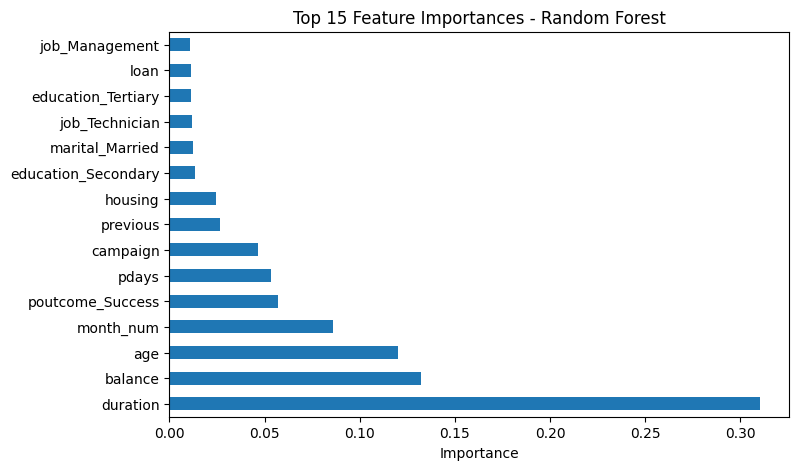

In [29]:
# Feature Importance
rf_importances = pd.Series(rf.feature_importances_, index=X.columns).nlargest(15)
plt.figure(figsize=(8,5))
rf_importances.plot(kind='barh')
plt.title("Top 15 Feature Importances - Random Forest")
plt.xlabel("Importance")
plt.show()

* XGBoost Classifier

In [30]:
# XGBoost Classifier
xgb = XGBClassifier(n_estimators=150, learning_rate=0.1, max_depth=5, random_state=42, eval_metric='logloss')

# Model Training
xgb.fit(X_train, y_train)

# Predictions
y_pred_xgb = xgb.predict(X_test)
y_proba_xgb = xgb.predict_proba(X_test)[:,1]

In [31]:
# Model Evaluation
acc_xgb = accuracy_score(y_test, y_pred_xgb)
prec_xgb = precision_score(y_test, y_pred_xgb)
rec_xgb = recall_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)
roc_xgb = roc_auc_score(y_test, y_proba_xgb)

In [32]:
print(" XGBoost Results")
print("Accuracy:", acc_xgb)
print("Precision:", prec_xgb)
print("Recall:", rec_xgb)
print("F1 Score:", f1_xgb)
print("ROC-AUC:", roc_xgb)

 XGBoost Results
Accuracy: 0.9046270901530568
Precision: 0.6402298850574712
Recall: 0.42133131618759456
F1 Score: 0.5082116788321168
ROC-AUC: 0.919885983065252


In [33]:
# Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))


Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.97      0.95      9981
           1       0.64      0.42      0.51      1322

    accuracy                           0.90     11303
   macro avg       0.78      0.69      0.73     11303
weighted avg       0.89      0.90      0.90     11303

Confusion Matrix:
 [[9668  313]
 [ 765  557]]


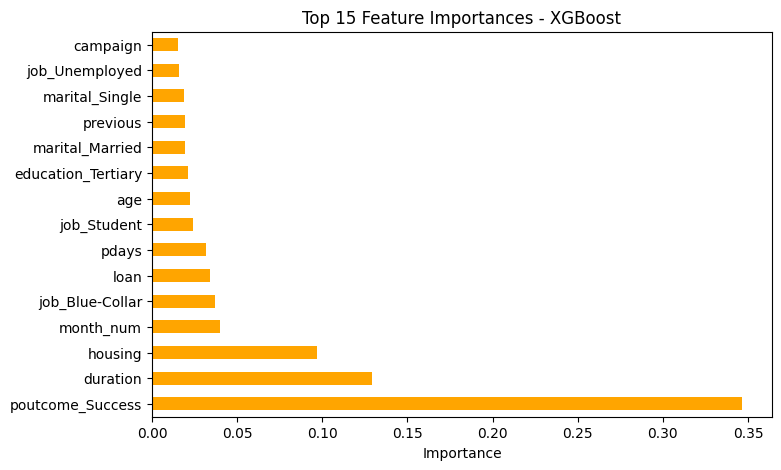

In [34]:
# Feature Importance
xgb_importances = pd.Series(xgb.feature_importances_, index=X.columns).nlargest(15)
plt.figure(figsize=(8,5))
xgb_importances.plot(kind='barh', color='orange')
plt.title("Top 15 Feature Importances - XGBoost")
plt.xlabel("Importance")
plt.show()

In [35]:
# Model Comparison
results_df = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost'],
    'Accuracy': [acc_rf, acc_xgb],
    'Precision': [prec_rf, prec_xgb],
    'Recall': [rec_rf, rec_xgb],
    'F1 Score': [f1_rf, f1_xgb],
    'ROC-AUC': [roc_rf, roc_xgb]
})

print("MODEL COMPARISON ")
print(results_df)

MODEL COMPARISON 
           Model  Accuracy  Precision    Recall  F1 Score   ROC-AUC
0  Random Forest  0.903035   0.645244  0.379728  0.478095  0.907794
1        XGBoost  0.904627   0.640230  0.421331  0.508212  0.919886


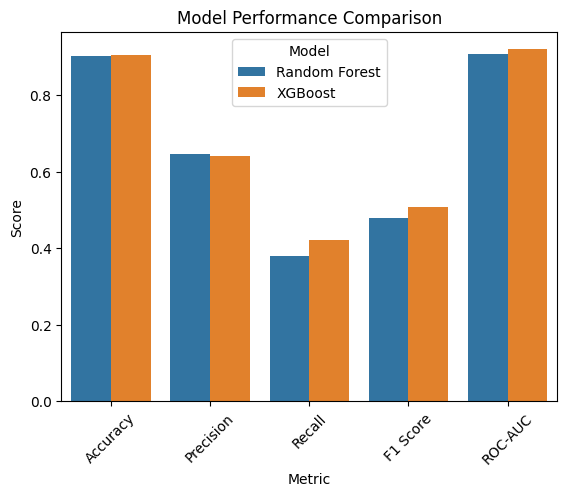

In [36]:
sns.barplot(data=results_df.melt(id_vars='Model', var_name='Metric', value_name='Score'),
            x='Metric', y='Score', hue='Model')
plt.title("Model Performance Comparison")
plt.xticks(rotation=45)
plt.show()